In [1]:
# =============================================================================
# Created By:     Kai Metzger
# Created School: Franz-Oberthuer-Schule Wuerzburg
# Created Email:  metzgerkai@franz-oberthuer-schule.de
# Created Date:   Mon Dec 01 17:25 UTC 2025
# Version:        1.0.0
# =============================================================================
"""The Module has been build for training the symbols dataset with images + 
ground truth. Images have the base dimenstions of 640px x 480px in datasets 1-8
and then another 700 images with resolution 1920px x 1080px have been added to  
the subsequent datasets.
The files in the dataset <symbols> should be ordered in the following
manner:             > explanation
- symbols      
  - dataset1        > dataset version (dataset1 - 3 where used in the project)
    - data          > images (.png files)
    - gt            > ground truth (.txt files with class labels 1-4)

  - # dataset/      e.g. daset10 the corresponding classes are stored in folders 0 - 3:
    #     classA/     = cross
    #     classB/     = circle 
    #     classC/     = triangle
    #     classD/     = rectangle
"""

# =============================================================================
# Import
# =============================================================================
import cv2
import os
import numpy as np
from keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import tensorflow_hub as hub
from keras.optimizers.schedules import ExponentialDecay

# Enable Nvidia GPUs by un-commenting this line 
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/"


2025-12-01 21:54:24.991689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/kai/.local/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
# =============================================================================
# Declare variables
# =============================================================================
# Change the following paths to your dataset path
home_dir = os.path.expanduser("~/git")
dataset_for_training = home_dir + "/ml_project/datasets/symbols/dataset10"

print("Dataset:", dataset_for_training)

Dataset: /home/kai/git/ml_project/datasets/symbols/dataset10


In [3]:
# =============================================================================
# Dataset related
# =============================================================================
NUM_CLASSES = 4
IMG_SIZE_X = 160
IMG_SIZE_Y = 160

IMG_SIZE = (IMG_SIZE_X, IMG_SIZE_Y)
#INPUT_SHAPE = (IMG_SIZE_X, IMG_SIZE_Y, 1) # grayscale
INPUT_SHAPE = (IMG_SIZE_X, IMG_SIZE_Y, 3) # color

# =============================================================================
# Hyperparameters
# =============================================================================
BATCH_SIZE = 64
EPOCHS = 300
LEARNING_RATE = 0.001

# Set up an exponential decay learning rate schedule
LR_SCHEDULE = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,  # start with 0.001
    decay_steps=100000,           # how often to apply the decay
    decay_rate=0.96,              # decay rate
    staircase=True                # whether to apply the decay in steps
)

OPTIMIZER = keras.optimizers.Adam(learning_rate=LR_SCHEDULE)

I0000 00:00:1764622469.865969   10300 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4617 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_for_training,
    labels="inferred",
    label_mode="categorical",           # 4 Klassen → 1-hot
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_for_training,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Klassen:", class_names)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 1400 files belonging to 4 classes.
Using 1120 files for training.
Found 1400 files belonging to 4 classes.
Using 280 files for validation.
Klassen: ['0', '1', '2', '3']


In [5]:
# =============================================================================
# Dataset
# =============================================================================
# =============================================================================
# Data Augmentation
# =============================================================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
])

"""resize_and_rescale_grayscale = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),  # Convert to grayscale
    layers.Resizing(IMG_SIZE_X, IMG_SIZE_Y),        # Resize image to the target size
    layers.Rescaling(1./255)                        # Rescale pixel values to [0, 1]
])
"""

'resize_and_rescale_grayscale = tf.keras.Sequential([\n    layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),  # Convert to grayscale\n    layers.Resizing(IMG_SIZE_X, IMG_SIZE_Y),        # Resize image to the target size\n    layers.Rescaling(1./255)                        # Rescale pixel values to [0, 1]\n])\n'

In [6]:
# =============================================================================
# MobileNetV2 (Transfer Learning)
# =============================================================================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))

x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# =============================================================================
# Training (Feature Extraction)
# =============================================================================
initial_epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

Epoch 1/10


2025-12-01 21:54:42.303982: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91501


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.2804 - loss: 1.6541 - val_accuracy: 0.3286 - val_loss: 1.4669
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.3518 - loss: 1.3893 - val_accuracy: 0.4250 - val_loss: 1.2681
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.4821 - loss: 1.1614 - val_accuracy: 0.5464 - val_loss: 1.1085
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5357 - loss: 1.0594 - val_accuracy: 0.6321 - val_loss: 0.9884
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5866 - loss: 0.9832 - val_accuracy: 0.6857 - val_loss: 0.8936
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6348 - loss: 0.9133 - val_accuracy: 0.7214 - val_loss: 0.8163
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7027 - loss: 0.8096 - val_accuracy: 0.7500 - val_loss: 0.7562
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7196 - loss: 0.7512 - val_accuracy: 0.7750 - val

In [9]:
# =============================================================================
# Fine Tuning
# =============================================================================
base_model.trainable = True
fine_tune_from = 100

for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.6357 - loss: 0.8999 - val_accuracy: 0.8321 - val_loss: 0.5290
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7402 - loss: 0.7196 - val_accuracy: 0.8500 - val_loss: 0.4733
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.7625 - loss: 0.6270 - val_accuracy: 0.8571 - val_loss: 0.4346
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.8018 - loss: 0.5314 - val_accuracy: 0.8679 - val_loss: 0.4020
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.8196 - loss: 0.4929 - val_accuracy: 0.8714 - val_loss: 0.3725
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.8438 - loss: 0.4335 - val_accuracy: 0.8857 - val_loss: 0.3468
Epoch 16/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.8670 - loss: 0.3805 - val_accuracy: 0.8893 - val_loss: 0.3309
Epoch 17/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.8741 - loss: 0.3487 - val_acc

In [10]:
# =============================================================================
# Test Accuracy (Validation = Test)
# =============================================================================
loss, acc = model.evaluate(val_ds)
print("Test Accuracy:", acc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8964 - loss: 0.2897
Test Accuracy: 0.8964285850524902


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Klassen: ['0', '1', '2', '3']


2025-12-01 21:56:30.964171: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


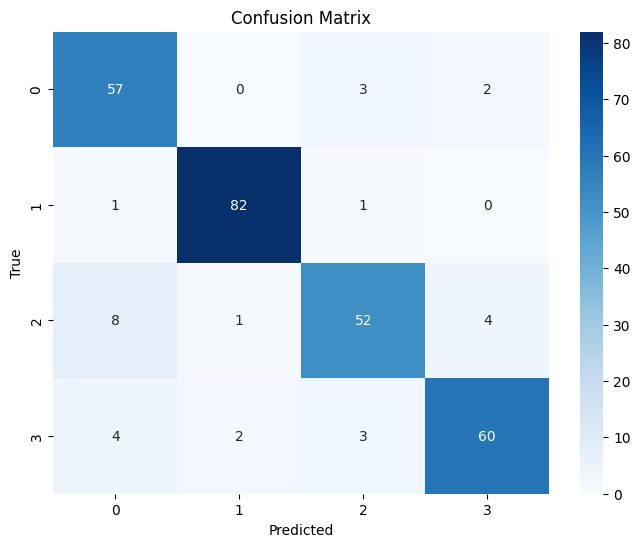


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        62
           1       0.96      0.98      0.97        84
           2       0.88      0.80      0.84        65
           3       0.91      0.87      0.89        69

    accuracy                           0.90       280
   macro avg       0.89      0.89      0.89       280
weighted avg       0.90      0.90      0.90       280



In [11]:
# =============================================================================
# Konfusionsmatrix + Klassifizierungsreport
# =============================================================================
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Daten aus Validation/Test holen
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Klassenliste
print("Klassen:", class_names)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [13]:
# =============================================================================
# Modell speichern
# =============================================================================
keras.saving.save_model(model, "model.keras")                 # Keras/H5 Format

print("Modelle gespeichert: model.keras/")


Modelle gespeichert: model.keras/


In [14]:
# =============================================================================
# Modell laden
# =============================================================================
loaded_model = keras.models.load_model("model.keras")

print("Modelle erfolgreich geladen!")


Modelle erfolgreich geladen!


In [15]:
# TODO
# =============================================================================
# TensorBoard Logging
# =============================================================================
log_dir = "logs/fit"
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# Beim Training einfügen:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[tensorboard_callback]
)

# Starten in Shell:
# tensorboard --logdir logs/fit

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.8946 - loss: 0.2807 - val_accuracy: 0.8964 - val_loss: 0.2832
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.9045 - loss: 0.2552 - val_accuracy: 0.9036 - val_loss: 0.2748
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9089 - loss: 0.2564 - val_accuracy: 0.9000 - val_loss: 0.2701
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9107 - loss: 0.2413 - val_accuracy: 0.8893 - val_loss: 0.2648
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9250 - loss: 0.2101 - val_accuracy: 0.9071 - val_loss: 0.2541
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9134 - loss: 0.2126 - val_accuracy: 0.9143 - val_loss: 0.2505
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9384 - loss: 0.1908 - val_accuracy: 0.9107 - val_loss: 0.2488
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9277 - loss: 0.1977 - val_accuracy: 0.

In [ ]:
# =============================================================================
# Grad-CAM Visualisierung
# =============================================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Modell: Feature-Extraktor + Klassifikationslayer trennen
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return heatmap.numpy(), int(pred_index.numpy())

# Name der letzten Convolution-Schicht in MobileNetV2:
last_conv_layer_name = "Conv_1"

# Beispielbild (nimm erstes Bild aus val_ds)
example_img, example_label = next(iter(val_ds))
example_img = example_img[0]
example_np = np.expand_dims(example_img, axis=0)

# Grad-CAM erzeugen
heatmap, predicted_class = make_gradcam_heatmap(example_np, model, last_conv_layer_name)

# Heatmap auf Original legen
img = example_img.numpy().astype("uint8")
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

# Anzeigen
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Overlay (Predicted: {class_names[predicted_class]})")
plt.imshow(superimposed_img)
plt.axis("off")

plt.show()


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m124356608472032\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         ...,\n         [100.5   , 117.    ,  76.5   ],\n         [109.25  , 122.25  , 104.3125],\n         [107.8125, 119.6875, 109.0625]],\n\n        [[  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         ...,\n         [106.625 , 121.625 ,  90.875 ],\n         [112.1875, 126.8125,  98.9375],\n         [111.4375, 126.4375,  94.8125]],\n\n        [[  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         ...,\n         [111.4375, 122.375 ,  95.0625],\n         [109.8125, 128.    , 105.125 ],\n         [115.4375, 129.4375, 104.4375]],\n\n        ...,\n\n        [[  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         ...,\n         [ 14.25  ,  26.25  ,   0.    ],\n         [ 20.    ,  32.    ,   0.    ],\n         [ 29.875 ,  36.25  ,   0.    ]],\n\n        [[  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         ...,\n         [ 20.5   ,  32.5   ,   0.    ],\n         [ 17.1875,  29.1875,   0.    ],\n         [ 20.5   ,  30.625 ,   0.    ]],\n\n        [[  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         [  5.    ,   5.    ,   5.    ],\n         ...,\n         [ 16.25  ,  27.625 ,   0.    ],\n         [ 18.75  ,  30.125 ,   0.    ],\n         [ 14.875 ,  32.0625,   0.    ]]]],\n      shape=(1, 160, 160, 3), dtype=float32)\n  • training=None\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(1, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
#print(IMG_SIZE)
#print(INPUT_SHAPE)
IMG_SHAPE = IMG_SIZE + (3,)
#print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
"""
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
"""

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])


In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
